In [1]:
import numpy as np
import pandas as pd

In [2]:
book = pd.read_csv("../input/goodreads-best-books-of-2018/book_data.csv")

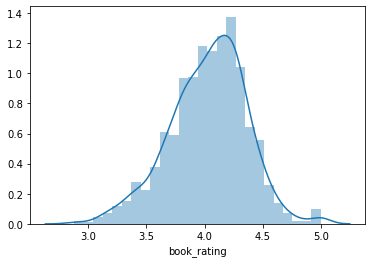

In [3]:
import seaborn as sns
sns.distplot(book["book_rating"]);

# Text Preprocessing

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
book['book_desc'] = book['book_desc'].astype(str)
book['cleaned'] = book['book_desc'].apply(_removeNonAscii)
book['cleaned'] = book.cleaned.apply(func = make_lower_case)
book['cleaned'] = book.cleaned.apply(func = remove_stop_words)
book['cleaned'] = book.cleaned.apply(func=remove_punctuation)
book['cleaned'] = book.cleaned.apply(func=remove_html)

# Splitting the descriptions into words and stored in a list called corpus

In [6]:
corpus = []

for words in book['cleaned']:
    corpus.append(words.split())

# Training corpus with Google Pretrained Word2Vec model

In [7]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

google_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

--2020-11-30 11:04:27--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.88.198
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.88.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  14.3MB/s    in 2m 6s   

2020-11-30 11:06:34 (12.5 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



(0, 0)

# Building the TF-IDF model

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english')
tfidf.fit(book['cleaned'])

tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names()

# Building TF-IDF Word2Vec Embeddings

In [9]:
import numpy as np

tfidf_vectors = []; 
line = 0;

for desc in corpus: 
    sent_vec = np.zeros(300) 
    weight_sum =0; 
    for word in desc: 
        if word in google_model.wv.vocab and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1

In [10]:
import pickle

filename = 'tfidf'
outfile = open(filename,'wb')
pickle.dump(tfidf_vectors,outfile)
outfile.close()

output = open(filename,'rb')
new_dict = pickle.load(output)
output.close()

In [11]:
import pickle

filename = "Model.pkl"  

with open(filename, 'wb') as file:  
    pickle.dump(tfidf_vectors, file)

In [12]:
with open(filename, 'rb') as file:  
    Model = pickle.load(file)

In [13]:
import joblib

joblib_file = "Model2.pkl"  
joblib.dump(tfidf_vectors, joblib_file)

['Model2.pkl']

In [14]:
model = joblib.load(joblib_file)

# Recommendation using TF-IDF Word2Vec

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_vectors, tfidf_vectors)

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = book.loc[book['book_title'].isin([title])]
    idx = idx.index
    sim_scores = list(enumerate(cosine_sim[idx][0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:5]
    indices = [i[0] for i in sim_scores]
    judul = book['book_title'].iloc[indices]
    return judul

In [16]:
get_recommendations("Circe")

860             The Darkest Warrior
183                The Sky Is Yours
134    Aru Shah and the End of Time
377                        Strength
Name: book_title, dtype: object

In [17]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def recommendations(title):
    cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)
    books = book[['book_title', 'image_url']]
    indices = pd.Series(book.index, index = book['book_title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_url'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['book_title'])

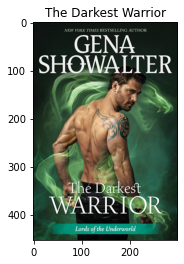

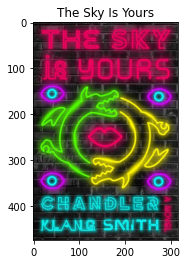

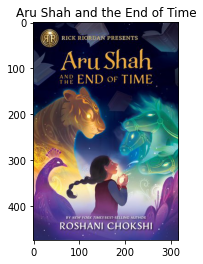

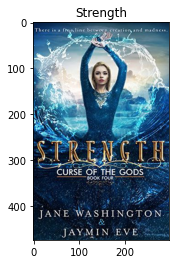

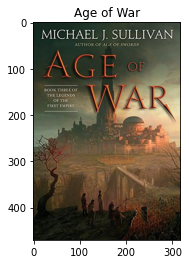

In [18]:
recommendations("Circe")